In [1]:
import sys
import re
import os
import numpy as np
import pandas as pd
import pysam
from Bio.Seq import Seq
from Bio import Restriction
from Bio import SeqIO
from rapidfuzz import fuzz
import rapidfuzz
import regex
import mappy as mp

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# params
ref_path = "/nfs/turbo/umms-indikar/shared/projects/poreC/data/references/fasta/Mus_musculus.GRCm39.dna.chromosome.19.fa.gz"
cutter = "CATG"

aligner = mp.Aligner(ref_path, preset='map-ont', n_threads=10)
print(aligner.seq_names)

# extract the reference sequence
ref_sequence = aligner.seq("19")
print(f"{len(ref_sequence)=}")

# get all cut sites
sites=[m.start() for m in re.finditer(cutter, ref_sequence)]
print(f"{len(sites)=}")
sites[:10]

['19']
len(ref_sequence)=61420004
len(sites)=282068


[3050012,
 3050435,
 3050653,
 3050956,
 3051394,
 3051547,
 3051728,
 3051849,
 3052134,
 3052154]

df.shape=(10000, 10)


alignable
True     0.7326
False    0.2674
Name: proportion, dtype: float64

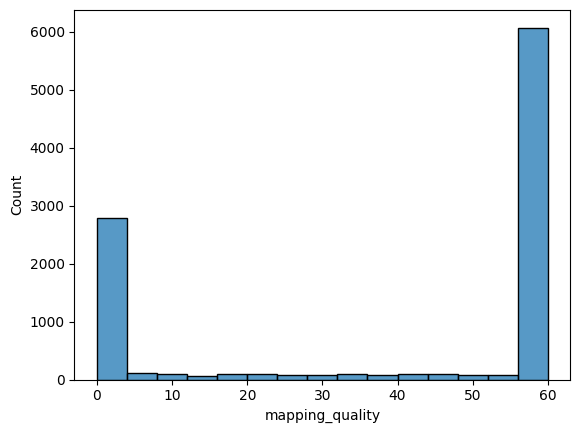

In [3]:
def sample_alignments(aligner, sites, sample_size=10000, n_sites_per_monomer=0):
    indices = list(range(len(sites)))
    sample_indices = np.random.choice(indices, sample_size, replace=False)
    
    res = []
    for s, i in enumerate(sample_indices):
        ref_start = sites[i]
        end_idx = i + (n_sites_per_monomer + 1)
        
        if end_idx >= len(sites):
            end_idx = len(sites) -1
            
        ref_end = sites[end_idx] 
    
        seq = aligner.seq("19", ref_start, ref_end)
    
        row = {
            'sample' : s,
            'seq_length' : len(seq),
            'true_ref_start' : ref_start,
            'true_ref_end' : ref_end,
        }
    
        for hit in aligner.map(seq): # traverse alignments
            if not hit is None:
                 row['align_end'] = hit.q_en
                 row['align_start'] = hit.q_st
                 row['align_ref_end'] = hit.r_en
                 row['align_ref_start'] = hit.r_st
                 row['mapping_quality'] = hit.mapq
        res.append(row)
    
    
    res = pd.DataFrame(res)
    res['mapping_quality'] = res['mapping_quality'].fillna(0)
    res['alignable'] = res['mapping_quality'] != 0 
    return res

df = sample_alignments(aligner, 
                       sites, 
                       sample_size=10000, 
                       n_sites_per_monomer=0)

print(f"{df.shape=}")

sns.histplot(data=df, x='mapping_quality')
df['alignable'].value_counts(normalize=True)

0 NlaIII sites per monomer
1 NlaIII sites per monomer
2 NlaIII sites per monomer
3 NlaIII sites per monomer
4 NlaIII sites per monomer
5 NlaIII sites per monomer
6 NlaIII sites per monomer
7 NlaIII sites per monomer
8 NlaIII sites per monomer
9 NlaIII sites per monomer


<AxesSubplot: xlabel='n_per_monomer', ylabel='proportion'>

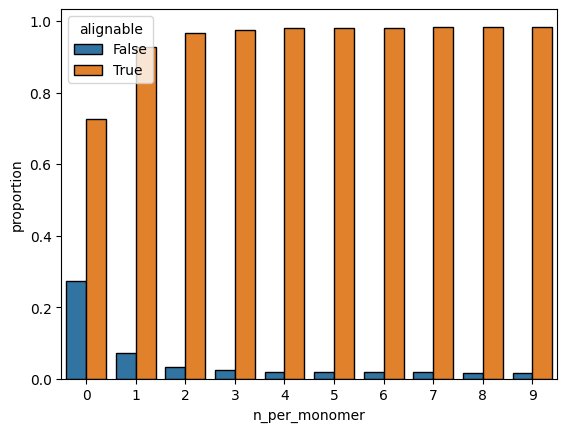

In [4]:
res = []
for i in range(0, 10):
    print(f"{i} NlaIII sites per monomer")
    df = sample_alignments(aligner, 
                           sites, 
                           sample_size=10000, 
                           n_sites_per_monomer=i)

    t = df['alignable'].value_counts(normalize=True)
    t = pd.DataFrame(t).reset_index(drop=False)
    t['n_per_monomer'] = i
    # print(t)
    res.append(t)

res = pd.concat(res)
res.head()

sns.barplot(data=res, 
            x='n_per_monomer',
            y='proportion',
            hue='alignable',
            ec='k')

<AxesSubplot: xlabel='n_per_monomer', ylabel='proportion'>

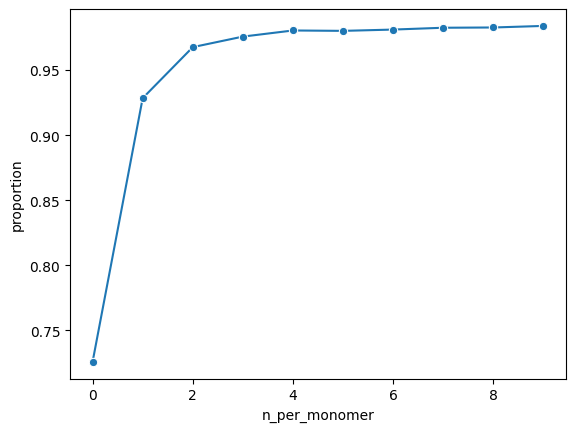

In [11]:
sns.lineplot(data=res[res['alignable']], 
             x='n_per_monomer',
             y='proportion',
             marker="o")